In [1]:
import matplotlib.pyplot as plt
import numpy as np
import wave
import os
import wavio
import scipy.signal
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler
import time
import pyloudnorm as pyln
import math
from scipy.fftpack import fft, ifft, rfft
plt.rcParams['font.sans-serif'] = ['SimHei']	# 显示中文
plt.rcParams['axes.unicode_minus'] = False		# 显示负号

In [2]:
#获得当前目录下所有文件列表
files = os.listdir()

#计算wav文件数量并print出文件名
filenum = 0 #轨道数量
filenames = []
for file in files:
    if '.wav' in file:
        filenum += 1
        filenames.append(file)
        print(file)
        
#取得所有轨道数据，存放于列表x中
x_1 = []  #将要用到的各轨道数据
nframes = []  #各轨道长度
rates = []
for file in files:
    if '.wav' in file:
        data = np.array(wavio.read(file).data)
        x_1.append(data)   
        nframes.append(data.shape[0]) 
        rates.append(wavio.read(file).rate)
x = np.zeros((max(nframes), filenum)) 

for track_num, track in enumerate(x_1):   
    for signal_num, signal in enumerate(track):
        if track.shape[1] == 1:
            x[signal_num, track_num] = signal
        if track.shape[1] == 2:
            x[signal_num, track_num] = (signal[0] + signal[1]) * 1.414  #所有双声道变单声道

x = x / x.max(axis=0) #归一化
rate = rates[0]
del x_1

#filenum 轨道数量
#x 各轨道原始数据
#rate 采样率

AG B DT.wav
BASS.wav
BV DT3.wav
EG DT.wav
HH.13.wav
KB.wav
Kick CON.13.wav
TB.13.wav
Vox.08.wav


In [3]:
#定义所用函数

def Loudness95dB_at_Fs44100(input1, rate, window):
    
    meter = pyln.Meter(rate, block_size=(window/4))
    
    '''
    input1：np.array列向量
    window: 窗长
    ------
    用于提取轨道的峰值特征
    '''
    
    '''input1 = np.delete(input1.reshape(-1, 1), np.all(input1==0, axis=1)) #数组重塑为列向量，删除所有0

    B = [1.176506, -2.353012, 1.176506]; A = [1, -1.960601, 0.961086];
    input1 = scipy.signal.filtfilt(B, A, input1, axis=0)
    B = [0.951539, -1.746297, 0.845694]; A = [1, -1.746297, 0.797233];
    input1 = scipy.signal.filtfilt(B, A, input1, axis=0)
    B = [1.032534, -1.42493, 0.601922]; A = [1, -1.42493, 0.634455];
    input1 = scipy.signal.filtfilt(B, A, input1, axis=0)
    B = [0.546949, -0.189981, 0.349394]; A = [1, -0.189981, -0.103657];
    input1 = scipy.signal.filtfilt(B, A, input1, axis=0)'''
    

    length = len(input1)
    S = int(window * rate)
    avin = np.arange(0, length, S) #avin装了每个窗的边界位置
    avin2 = np.append(avin, length)
    peakA = []
    for i, bias in enumerate(avin):
        signal = input1[avin2[i]: avin2[i+1]]
        loud = meter.integrated_loudness(signal)
        peakA.append(loud)
    print("{} sample points in this feature track".format(len(peakA)))      
    return peakA

def LoudnessProcessing(x, cv, cvpan, form='post'):
    
    '''
    x:list,每个元素是一个单声道或双声道信号
    cv：list，每个元素是float，代表各推子值 
    ------
    用于将各轨道的音量按照给出的各推子值进行缩放并混缩
    '''
    cv = np.array(cv)
    x_final = cv * x
    x_left = []; x_right = []
    for i in cvpan:
        x_left.append(math.sin(0.5 * np.pi * i))
        x_right.append(math.cos(0.5 * np.pi * i))
        
    yL = np.zeros(x.shape[0])
    yR = np.zeros(x.shape[0])
    for i in range(x.shape[1]):
        yL += x[:, i] * x_left[i]
        yR += x[:, i] * x_right[i]
    Y = np.vstack((yL, yR)).T
    if form == 'pre':
        return x_final
    elif form == 'post':
        return Y
    
    

def LoudnessSideChain_at_Fs44100(x, tr, rate, window): #x为矩阵，每列是一个轨道
    #该函数用于获取各推子的值
    
    tracknum = x.shape[1] #轨道数量

    #噪声门 去掉所有小于tr的点
    xg = gater(x, tr)
    print("Noise gate Clear")
    #特征提取
    xg2 = [] #用于存放所有轨道特征
    for m in range(tracknum):
        start = time.time()
        
        xg2m = Loudness95dB_at_Fs44100(xg[:, m].reshape(-1, 1), rate=rate, window=window) #提取好的单轨特征
        xg2.append(xg2m)
        
        end = time.time()
        print("{} track feature extraction clear, in {}".format(m, (end-start)))
    print("All track feature extraction clear")
    #累加特征计算
    xg2 = normalizer(xg2) #归一化
    #此时xg2的每一条轨道都是归一化的峰值特征
    
    fv = []
    plt.figure(figsize=(30, 20))
    rownum = (tracknum // 2) + 1#每行两个图的话有多少行
    
    bars = 50
    bins = np.linspace(0, 1, bars)
    
    
    for m in range(tracknum):
        start = time.time()
        fig_m = plt.subplot(rownum, 2, m+1)
        var = np.var(xg2[m])  #方差
        n, bins, patches = plt.hist(xg2[m], bins=bins, density=True)
        #n[0]=0 #非常关键！！！
        fig_m.set_title('track{}, var={}'.format(m+1, var))
        maxhist = max(n)
        maxhist_arg = np.argmax(n)#将xg2的单轨放置在直方图内，maxhist是最密集区间的样本数，maxhist_arg是最密集的是第几个区间
        maxhist_arg += 1
        #计算每个轨道最有可能的响度值
        if var <= 0.03:
            fvm = maxhist_arg * (1-tr) / bars #该特征轨道最大值与最小值的和，除以15再乘以在第几个区间最密集
            
        if var > 0.03:
            fvm = np.mean(xg2[m])
            
        print("{}!!".format(fvm))   
        end = time.time()
        print("{} track histogram Clear, in{}".format(m, (end-start)))
        fv.append(fvm)

    print("Fv feature caculate Clear")
    #CROSS ADAPTIVE PROCESSING
    print(fv)
    
    l = np.mean(fv)
    print("Average value of Fv: {}".format(l))
    
    
    cva = []
    for m in range(tracknum):
        cva_m = l / fv[m] #compensate for average loudness
        cva.append(cva_m)

    #Unity gain normalisation to maintain system stability
    cvasum = sum(cva) #obtain total non-nomalized
    cv = []
    for m in range(tracknum):
        cv_m = cva[m] / cvasum #normalize for cvasum
        cv.append(cv_m)
        
    print("cv feature caculate Clear")
    
    #人声增强
    cv[-1] *= 1.0
    sumcv = sum(cv)
    cv_gain = []
    for i in cv:
        cv_gain.append((i / sumcv))
    print("Voice enhanced：{}".format(cv_gain))
    return cv_gain


In [4]:
def normalizer(x):
    
    '''
    x:list,里面装的各轨道原始lufs特征
    ================
    归一化的
    '''
    tracknum = len(x)

    x_norms = []
  
    
    #先去掉原始特征轨道中的inf
    for track in x:
        for i in range(len(track)-1, -1, -1):
            if abs(track[i]) == np.float64('inf'):
                track.pop(i)  
    max_vector = [] #每轨的爷
    min_vector = [] #每轨的弟弟
    for m in range(tracknum):
        max_vector.append(max(x[m]))
        min_vector.append(min(x[m]))

    max_xg = max(max_vector)  #爷中爷
    min_xg = min(min_vector)  #弟中弟
    
    
    
    for track in x:
        x_norm = []
        
        for i in track:     
            x_new = (i - min_xg )/ (max_xg - min_xg)
            x_norm.append(x_new)
                
        x_norms.append(x_norm)
    return x_norms

def gater(x, tr):
    '''
    x:list
    tr:float
    ----------
    噪声门
    '''
    b = x.copy()
    b[b <= tr] = 0
        
    return b

def track_padding(x):
    '''
    补0的
    '''
    track_lens=[]
    for track in x:
        track_len = track.shape[0]
        track_lens.append(track_len)
        max_len = max(track_lens)

        
    for i, track in enumerate(x):
        if track.shape[1] == 1: #若为单轨
            delta_len = max_len - track.shape[0]
            zeros = np.zeros((delta_len, 1))
            x[i] = np.append(track, zeros, axis=0)
        if track.shape[1] == 2: #若为双轨
            delta_len = max_len - track.shape[0]
            zeros = np.zeros((delta_len, 2))
            x[i] = np.append(track, zeros, axis=0)
            
#做伽玛通滤波器的
import math
#pass_freq和pass_band可以是包含多个频道参数的向量
def make_erb_pass_allpole_cascade(x, rate):
    '''
    fs:采样率
    N:轨道数
    ==============================
    返回伽玛通滤波器的频域序列
    '''
    N = x.shape[1]
    filenum = N
    SF = 1 / N * 9.26 * (math.log(0.5 * rate + 228.7) - math.log(20 + 228.7))
    f_0 = []
    for n in range(N):
        f = - 228.7 + (0.5 * rate + 228.7) / math.exp(0.108 * (n+1) * SF);
        f_0.append(f)
    
    f_0 = np.array(f_0) #中心频率
    B = 24.7 * (0.00437 * f_0 + 1) #等效带宽
    print("Central frequency{}".format(f_0))
    print("Band widths:{}".format(B))
    
    g_ffts = []
    for index in zip(f_0, B):
        ts = np.linspace(0, 1, rate)
        gt = np.zeros(len(ts))
        for i, t in enumerate(ts): 
            A = t**1
            B = math.exp(-2*np.pi*index[1]*t) 
            C = math.cos(2*np.pi*index[0]*t)
            gt[i]=A*B*C
        half_n = rate//2    
        g_fft = np.abs(fft(gt, n=rate))
        g_fft = np.array(g_fft[:half_n])
        max1 = np.max(g_fft)
        g_fft = g_fft / max1
        g_ffts.append(g_fft)   
    
    rmss = np.zeros((filenum, filenum))  #每列是音轨 每行是同一个滤波器
    plt.figure(figsize=(30, 40))
    for i in range(filenum):
        x_14 = x[:,i]
        x_fft = np.abs(rfft(x_14))
        step = len(x_fft)//(rate//2)  
        x_fft = x_fft[::step]  #降采样
        maxfft = max(x_fft)
        x_fft = x_fft / maxfft
        delta = len(x_fft) - rate//2
        arg_del = np.arange(1, delta+1) * -1
        x_fft = np.delete(x_fft, arg_del)

        fig = plt.subplot(filenum, 2, i+1)
        fig.plot(x_fft)

        for m in range(len(g_ffts)):
            fig.plot(g_ffts[m], alpha=0.5)

        fig.set_title('{}'.format(filenames[i]))
        fig.set_xlim(0, 5000)

        for m, g_fft in enumerate(g_ffts):
            x_filted = x_fft*g_fft
            rms = sum(x_filted * x_filted)
            arg = np.argmax(rms)
            rmss[m, i] = (rms)
            
    list1 = range(filenum)
    arg_rmss = []
    for i in range(filenum):
        x3 = rmss[:, i]
        arg = np.argmax(x3)
        arg_rmss.append(arg)

    d1 = zip(filenames, arg_rmss)
    pan_dict = dict(d1)
    pan_dict_whole = pan_dict.copy()
    
    for i, file in enumerate(pan_dict.keys()):
        print('{} {}'.format(i,file))
    unpan = input('Please input the track number you dont want to pan (use space to devide).请输入不想偏移的轨道号,以空格相隔').split()
    print('track {}will not be paned'.format(unpan))
    unpan_int = []
    for un in unpan:
        un = int(un)
        unpan_int.append(un)
    unpan_int.sort(reverse=True)
    for un in unpan_int:
        print(list(pan_dict.keys())[un])
        del pan_dict['{}'.format(list(pan_dict.keys())[un])]      
    return pan_dict_whole, pan_dict

#切洋葱算法
def onion_cut(minpan, maxpan, dict1):
    
    onion = dict1.copy()
    dict1 = sorted(dict1.items(),key=lambda x:x[1],reverse=False)
    dict1 = dict(dict1)
    
    keys = list(dict1.keys())
    values = list(dict1.values())
    values_cata = list(set(list(dict1.values())))
    total_layer = len(values_cata)
    
    cutnum = total_layer // 4  #扒几次皮 每次扒两层
    heart_layer = total_layer % 4  #洋葱心有几层

    print('All tracks: {}'.format(values))
    print('Frequency distribution{}'.format(values_cata))
    cvpan_left = []; cvpan_right = []
    if total_layer >= 4:
        print('!!!!!!!!!!!')
        for i in range(cutnum):#扒皮
            tracknum_left = values.count(values_cata[0]) + values.count(values_cata[1])
            tracknum_right = values.count(values_cata[-1]) + values.count(values_cata[-2])
            cv_left, cv_right = list(np.linspace(minpan, maxpan, tracknum_left+2)), list(np.linspace(minpan, maxpan, tracknum_right+2))
            del cv_left[0]; del cv_left[-1]
            del cv_right[0]; del cv_right[-1]  #不取极左极右

            for cv in cv_left:
                cvpan_left.append(cv)
            for cv in cv_right:
                cvpan_right.append(cv)
            del values_cata[0:2] 
            del values_cata[-2:]

    if heart_layer == 1:
        tracknum_middle = values.count(values_cata[0])
        cvpan_middle = list(np.linspace(minpan, maxpan, tracknum_middle+2)) #如果芯部只有一个频段，则pan这个频段
        del cvpan_middle[0]; del cvpan_middle[-1]
        
        
    elif heart_layer == 2:
        tracknum_middle = values.count(values_cata[0]) + values.count(values_cata[1])
        cvpan_middle = list(np.linspace(minpan, maxpan, tracknum_middle+2))  #如果芯部有两个频段，则两个频段二合一再pan
        
    elif heart_layer == 3:
        cvpan_middle = list(np.linspace(minpan, maxpan, values.count(values_cata[0])+2)) 
        del cvpan_middle[0]; del cvpan_middle[-1]
        cvpan_middle2 = list(np.linspace(minpan, maxpan, values.count(values_cata[1])+2))
        del cvpan_middle2[0]; del cvpan_middle2[-1]
        cvpan_middle3 = list(np.linspace(minpan, maxpan, values.count(values_cata[2])+2))
        del cvpan_middle3[0]; del cvpan_middle3[-1]

        cvpan_middle.extend(cvpan_middle2)
        cvpan_middle.extend(cvpan_middle3)
    else:
        cvpan_middle = []
    cvpan_right.reverse()
    cvpan_left.extend(cvpan_middle)
    cvpan_left.extend(cvpan_right)
    
    print('\n\n\n')
    for index in zip(keys, values, cvpan_left):
        print('Track name: {}, Frequency distribution: {}, pan value: {}'.format(index[0], index[1], index[2]))
    
    
        
    return dict(list(zip(keys, cvpan_left)))

噪声门完毕
特征轨道共有159个点
第0轨特征提取完毕, 用时0.6963813304901123
特征轨道共有159个点
第1轨特征提取完毕, 用时0.7554655075073242
特征轨道共有159个点
第2轨特征提取完毕, 用时0.687401294708252
特征轨道共有159个点
第3轨特征提取完毕, 用时0.6368837356567383
特征轨道共有159个点
第4轨特征提取完毕, 用时1.3461432456970215
特征轨道共有159个点
第5轨特征提取完毕, 用时0.6497619152069092
特征轨道共有159个点
第6轨特征提取完毕, 用时2.0231549739837646
特征轨道共有159个点
第7轨特征提取完毕, 用时0.9771418571472168
特征轨道共有159个点
第8轨特征提取完毕, 用时0.6969382762908936
特征提取完毕
0.7178!!
第0轨直方图fv计算完毕, 用时0.09850120544433594
0.6596!!
第1轨直方图fv计算完毕, 用时0.04860568046569824
0.8490443829380667!!
第2轨直方图fv计算完毕, 用时0.05505657196044922
0.7565999999999999!!
第3轨直方图fv计算完毕, 用时0.05703997611999512
0.6990586267803037!!
第4轨直方图fv计算完毕, 用时0.046129465103149414
0.7759999999999999!!
第5轨直方图fv计算完毕, 用时0.045655012130737305
0.6596!!
第6轨直方图fv计算完毕, 用时0.04464077949523926
0.873!!
第7轨直方图fv计算完毕, 用时0.04429817199707031
0.8342!!
第8轨直方图fv计算完毕, 用时0.044487714767456055
fv计算完毕
[0.7178, 0.6596, 0.8490443829380667, 0.7565999999999999, 0.6990586267803037, 0.7759999999999999, 0.6596, 0.873, 0.8342]
fv的均值为0.75

请输入不想偏移的轨道号,以空格相隔 1 6 8


轨道['1', '6', '8']将不被pan
Vox.08.wav
Kick CON.13.wav
BASS.wav
{'AG B DT.wav': 7, 'BV DT3.wav': 5, 'EG DT.wav': 7, 'HH.13.wav': 1, 'KB.wav': 6, 'TB.13.wav': 7}
所有轨道为[1, 5, 6, 7, 7, 7]
频率分布为[1, 5, 6, 7]
!!!!!!!!!!!




轨道名HH.13.wav, 频段分布1, pan值为0.3333333333333333
轨道名BV DT3.wav, 频段分布5, pan值为0.6666666666666666
轨道名KB.wav, 频段分布6, pan值为0.8
轨道名AG B DT.wav, 频段分布7, pan值为0.6000000000000001
轨道名EG DT.wav, 频段分布7, pan值为0.4
轨道名TB.13.wav, 频段分布7, pan值为0.2


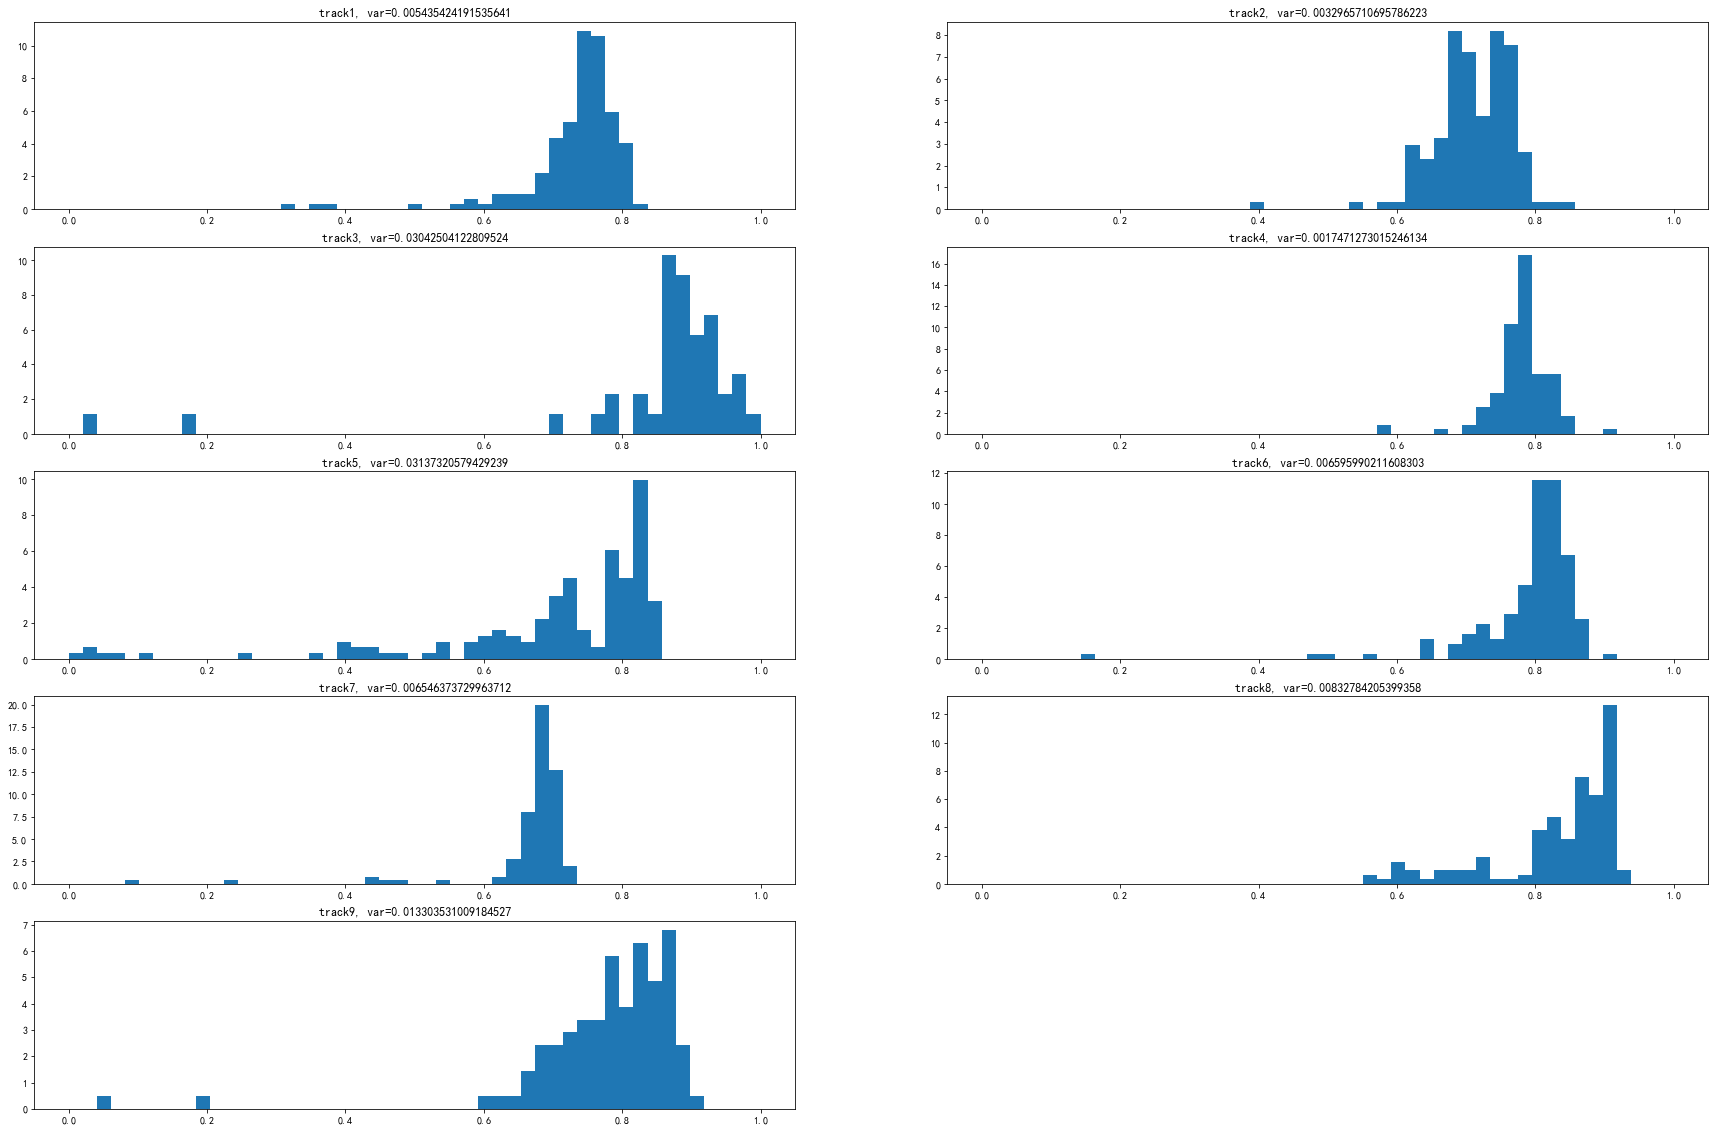

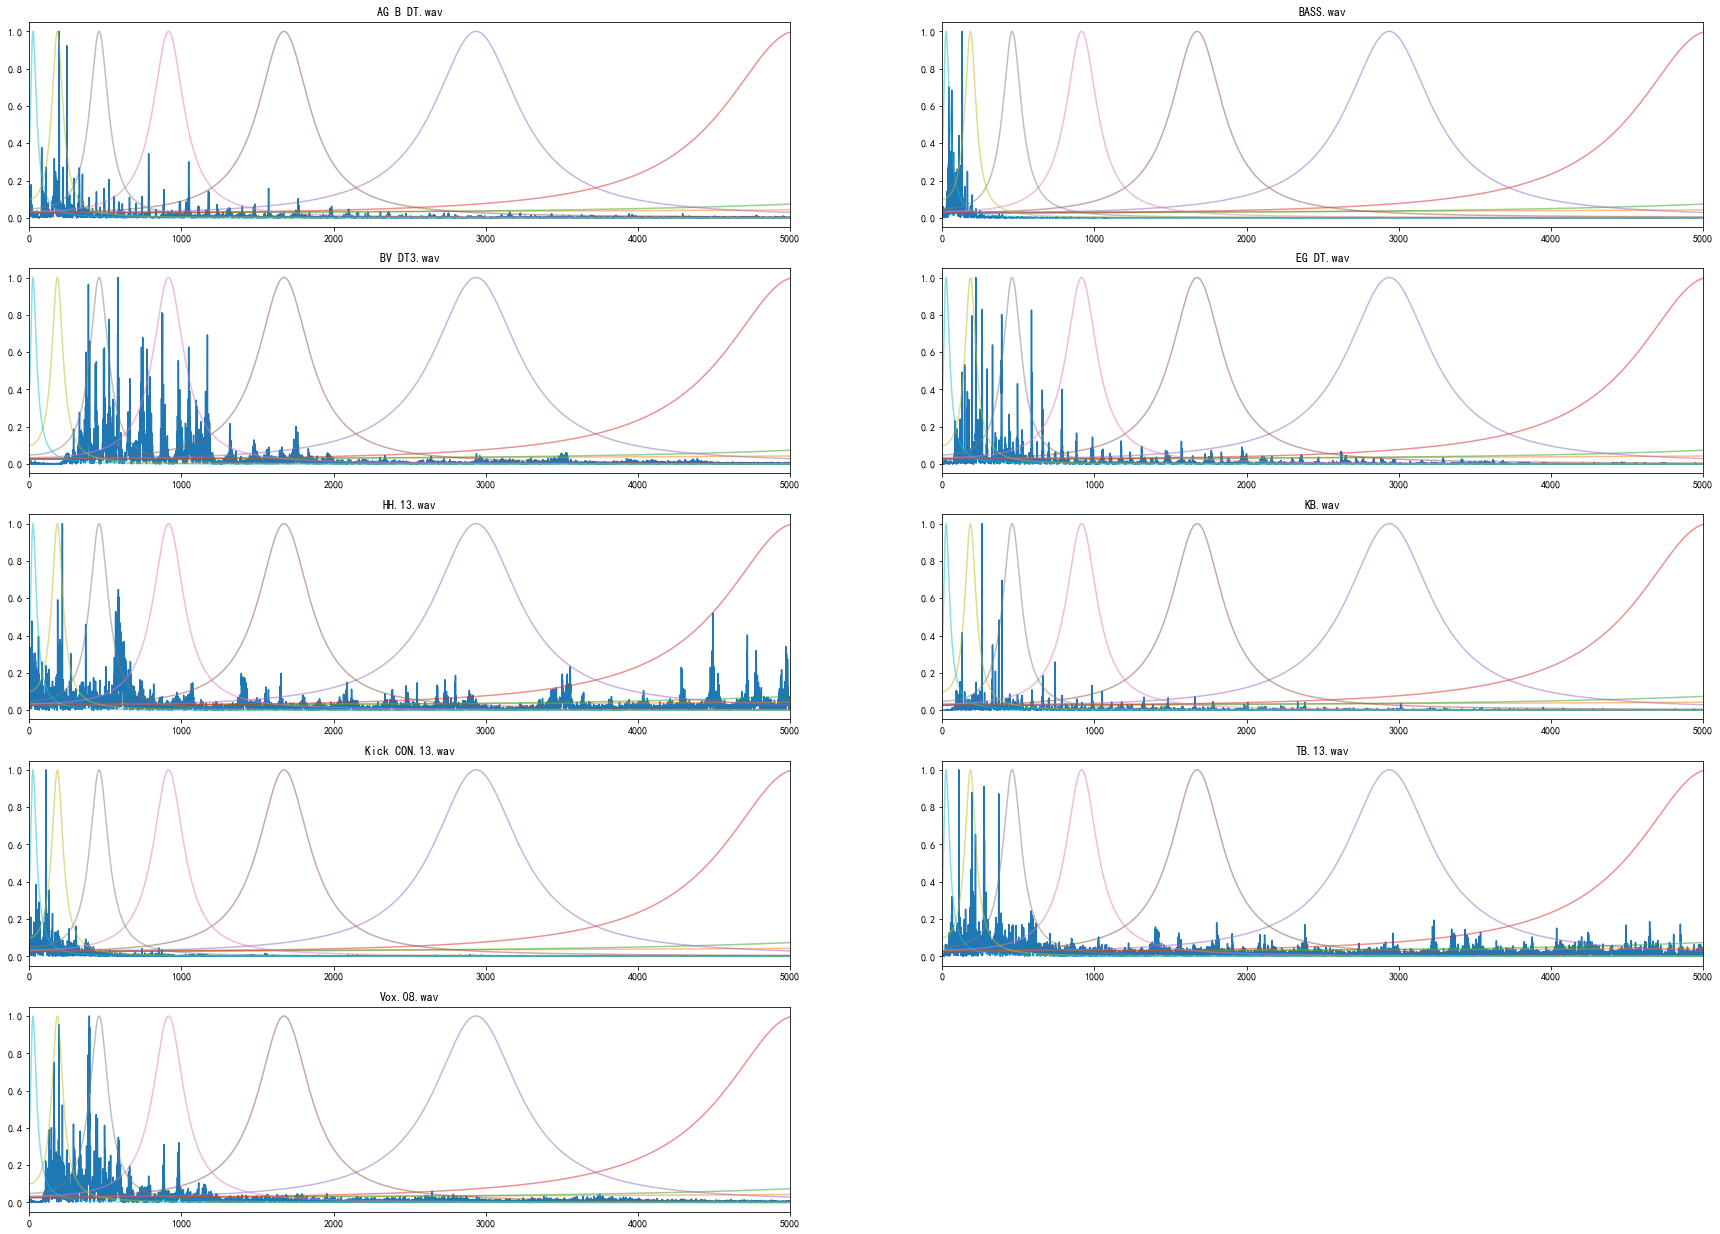

In [5]:
tr = 0.03
cv = LoudnessSideChain_at_Fs44100(x, tr=tr, rate=44100, window=2)
pan_dict_whole, pan_dict = make_erb_pass_allpole_cascade(x, rate)
for key in pan_dict_whole.keys():
    pan_dict_whole['{}'.format(key)] = 0.5  #将字典所有value设置0.5
print(pan_dict)
cvpan = onion_cut(0, 1, pan_dict)
for cv_, key in zip(cvpan.values(), cvpan.keys()):
    pan_dict_whole['{}'.format(key)] = cv_

In [6]:
cvpan_sort = []
for filename in filenames:
    cvp = pan_dict_whole['{}'.format(filename)]
    cvpan_sort.append(cvp)
 

In [7]:
pan_dict_whole

{'AG B DT.wav': 0.6000000000000001,
 'BASS.wav': 0.5,
 'BV DT3.wav': 0.6666666666666666,
 'EG DT.wav': 0.4,
 'HH.13.wav': 0.3333333333333333,
 'KB.wav': 0.8,
 'Kick CON.13.wav': 0.5,
 'TB.13.wav': 0.2,
 'Vox.08.wav': 0.5}

In [8]:
for index in zip(filenames, cv, cvpan_sort):
    print(index)

('AG B DT.wav', 0.11621006832309247, 0.6000000000000001)
('BASS.wav', 0.1264638978810124, 0.5)
('BV DT3.wav', 0.09824643884182024, 0.6666666666666666)
('EG DT.wav', 0.11025057763985698, 0.4)
('HH.13.wav', 0.11932559566070726, 0.3333333333333333)
('KB.wav', 0.10749431319886055, 0.8)
('Kick CON.13.wav', 0.1264638978810124, 0.5)
('TB.13.wav', 0.09555050062120937, 0.2)
('Vox.08.wav', 0.0999947099524284, 0.5)


([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

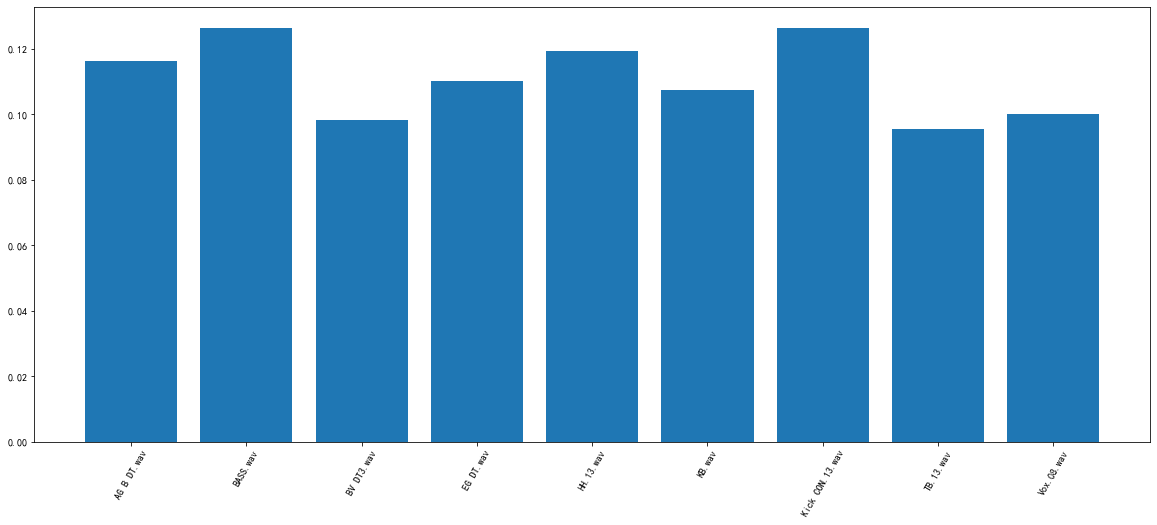

In [9]:
plt.figure(figsize=(20, 8))
plt.bar(filenames, cv)
plt.xticks(rotation=60)

In [10]:
x_final = LoudnessProcessing(x, cv, cvpan_sort)

In [11]:
wavio.write('mixed.wav', x_final, rate=rate, sampwidth=3)
print('mixed.wav has been outputed')